In [3]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy_ext import rolling_apply

from qtrader.core.security import Security, Currency
from qtrader.core.constants import Exchange
from qtrader.core.data import _get_data
from qtalib.indicators import CYC
from qtrader_config import *

In [4]:
def load_data(
        security: Security,
        data_start: datetime,
        start: datetime,
        end: datetime,
        lookback_period: int = None
) -> pd.DataFrame:
    """Load OHLCV"""
    data = _get_data(
        security=security,
        start=data_start,
        end=end,
        dfield="kline",
        dtype=['time_key', 'open', 'high', 'low', 'close', 'volume']
    ).set_index("time_key")
    data = data.ffill().bfill()
    if data[data.index <= start].shape[0] < lookback_period:
        raise ValueError("There is not enough lookback data, change data_start")
    ret_data = pd.concat(
        [data[data.index <= start].iloc[-lookback_period:],
         data[data.index > start]]
    )
    return ret_data

In [5]:
security = Currency(
    code="BTC.USD",
    lot_size=1,
    security_name="BTC.USD",
    exchange=Exchange.SMART
)

data_start = datetime(2020, 11, 15, 0, 0, 0)
start = datetime(2021, 1, 1, 0, 0, 0)
end = datetime(2021, 12, 31, 23, 59, 59)
lookback_window = 60

# Load data
data = load_data(security, data_start, start, end, lookback_window)

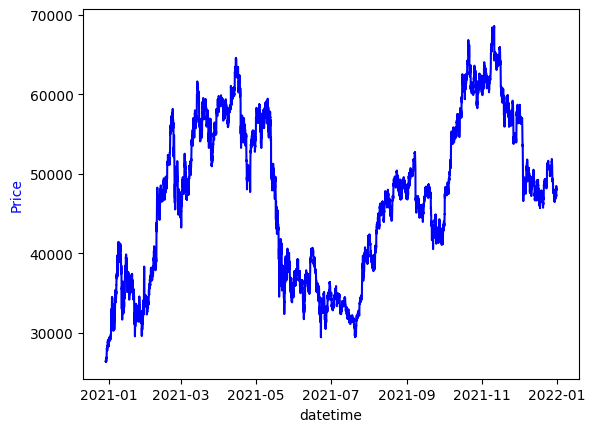

In [6]:
fig, ax1 = plt.subplots()
ax1.plot(data.index, data.close, 'b-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='b')
plt.show()

In [7]:
cyc = {
    "close": 0,
    "volume": 0
}
PCY = []
VOC = []
for idx in range(lookback_window, data.shape[0]):
    data_lb = data.iloc[idx-lookback_window+1:idx+1]
    closes = data_lb["close"].to_numpy()
    volumes = data_lb["volume"].to_numpy()
    cyc["close"] = CYC(
        data=closes,
        cyc=cyc["close"],
        short_ma_length=10,
        long_ma_length=50,
        alpha=0.33,
        lookback_window=10,
    )
    PCY.append(cyc["close"])
    cyc["volume"] = CYC(
        data=volumes,
        cyc=cyc["volume"],
        short_ma_length=10,
        long_ma_length=30,
        alpha=0.33,
        lookback_window=10,
    )
    VOC.append(cyc["volume"])

In [8]:
data_bt = data.iloc[lookback_window:].copy()
data_bt["VOC"] = VOC
data_bt["PCY"] = PCY

In [9]:
corr_pcy = np.corrcoef(
    data_bt.close.diff().apply(lambda x: int(x>0)),
    data_bt.PCY.diff().apply(lambda x: int(x>0))
)
corr_voc = np.corrcoef(
    data_bt.close.diff().apply(lambda x: int(x>0)),
    data_bt.VOC.diff().apply(lambda x: int(x>0))
)

In [10]:
print(
    f"VOC range: [{data_bt['VOC'].min()}, {data_bt['VOC'].max()}]\n"
    f"Correlation(VOC, price): {corr_voc[0][1]}\n"
    f"PCY range: [{data_bt['PCY'].min()}, {data_bt['PCY'].max()}]\n"
    f"Correlation(PCY, price): {corr_pcy[0][1]}\n"
)

VOC range: [0.00040769516008615415, 0.9999478612870939]
Correlation(VOC, price): 0.007333633842133367
PCY range: [0.0, 0.9999999247164753]
Correlation(PCY, price): 0.09085978611640602



buy & sell signals

In [11]:
data_bt["buy_signal1"] = rolling_apply(
    lambda VOC: int(VOC[0]>VOC[1] and VOC[2]>VOC[1]),
    3,
    data_bt.VOC.values
)
data_bt["buy_signal2"] = rolling_apply(
    lambda VOC, PCY: int(VOC[0]>VOC[1] and VOC[2]>VOC[1] and PCY[2]>PCY[1]),
    3,
    data_bt.VOC.values, data_bt.PCY.values
)
xi = 0.2
data_bt["buy_signal3"] = rolling_apply(
    lambda VOC, PCY: int(
        VOC[0]>VOC[1]
        and VOC[2]>VOC[1]
        and PCY[2]>PCY[1]
        and PCY[2] < xi
    ),
    3,
    data_bt.VOC.values, data_bt.PCY.values
)
data_bt["sell_signal1"] = rolling_apply(
    lambda VOC, PCY: -int(VOC[0]<VOC[1] and VOC[2]<VOC[1] and PCY[2]>0.9),
    3,
    data_bt.VOC.values,
    data_bt.PCY.values
)

In [12]:
data_bt_plot = data_bt[
    (data_bt.index > datetime(2021, 5, 5))
    & (data_bt.index < datetime(2021, 5, 10))
]
data_bt_plot_signal1 = data_bt_plot[data_bt_plot.buy_signal1==1]

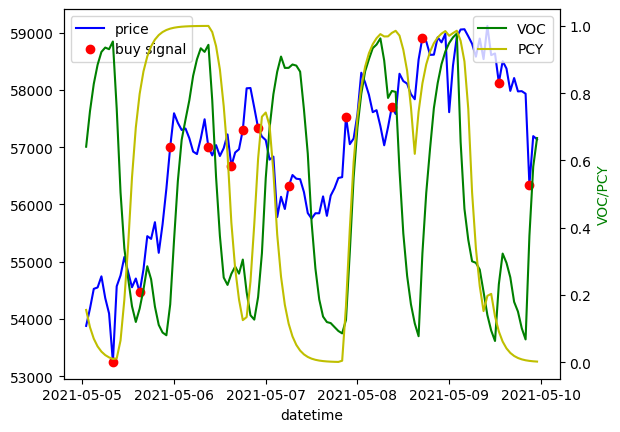

In [13]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_bt_plot.index, data_bt_plot.close, 'b-', label='price')
ax1.plot(data_bt_plot_signal1.index, data_bt_plot_signal1.close, 'ro', label='buy signal')
ax2.plot(data_bt_plot.index, data_bt_plot.VOC, 'g-', label='VOC')
ax2.plot(data_bt_plot.index, data_bt_plot.PCY, 'y-', label='PCY')
ax1.legend(loc=0)
ax2.legend(loc=1)
ax1.set_xlabel('datetime')
ax2.set_ylabel('Price', color='b')
ax2.set_ylabel('VOC/PCY', color='g')

plt.show()

In [16]:
buy_signal = "buy_signal3"
sell_signal = "sell_signal1"
stop_loss = 0.01
pos = 0
open_time = None
close_time = None
cost = None
trades = []
stop_trades = []
pnls = []
for row_idx, row in data_bt.iterrows():
    # if row_idx > datetime(2021,2,1):
    #     break
    pnl = 0
    if pos == 0 and row[buy_signal] == 1:
        cost = row.close
        pos = 1
        open_time = row_idx
    elif pos == 1 and row[sell_signal] == -1:
        pos = 0
        close_time = row_idx
        pnl = (row.close - cost) / cost
        trades.append([
            open_time,
            close_time,
            pnl
        ])
    elif pos == 1 and row.close/cost - 1 < -stop_loss:
        pos = 0
        close_time = row_idx
        pnl = (row.close - cost) / cost
        trades.append([
            open_time,
            close_time,
            pnl
        ])
        stop_trades.append([
            open_time,
            close_time,
            pnl
        ])

    pnls.append(pnl)
data_bt["equity"] = np.cumsum(pnls)

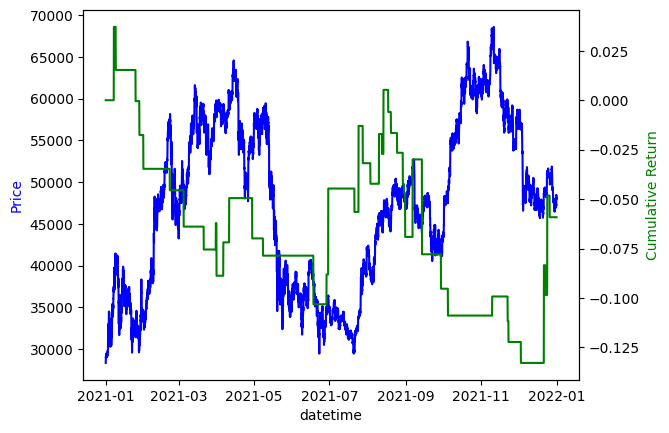

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_bt.index, data_bt.close, 'b-')
ax2.plot(data_bt.index, data_bt.equity, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='b')
ax2.set_ylabel('Cumulative Return', color='g')
plt.show()

In [23]:
num_trades = len(trades)
num_stop_trades = len(stop_trades)
trades_pnl = [t[-1] for t in trades]
win_trades_pnl = [t[-1] for t in trades if t[-1]>0]
num_win_trades = len(win_trades_pnl)
lose_trades_pnl = [t[-1] for t in trades if t[-1]<=0]
num_lose_trades = len(lose_trades_pnl)
stop_trades_pnl = [t[-1] for t in stop_trades]

In [24]:
print(
    f"number of trades: {num_trades}\n"
    f"number of stop trades: {num_stop_trades}\n"
    f"number of win trades: {num_win_trades}\n"
    f"number of lose trades: {num_lose_trades}\n"
    f"win trade ratio: {num_win_trades/num_trades}\n"
    f"maximum win trade: {max(trades_pnl)}\n"
    f"maximum lose trade: {min(trades_pnl)}\n"
)

number of trades: 42
number of stop trades: 27
number of win trades: 13
number of lose trades: 29
win trade ratio: 0.30952380952380953
maximum win trade: 0.050246895725294935
maximum lose trade: -0.04796189490696408

